# Определение возраста покупателей

## Задача

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

**Необходимо постройть модель, которая по фотографии определит приблизительный возраст человека и добиться значения MAE на тестовой выборке не больше 8. В нашем распоряжении набор фотографий людей с указанием возраста.**

## План работы

1. Исследовательский анализ набора фотографий.
2. Обучение нейронных сетей.
3. Анализ моделей.

# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications import Xception, DenseNet169, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
RND = 2102

In [3]:
def first_look(df):
    display(labels.head(5))
    display(df.info())
    print(df.describe())
    
    labels.hist(bins=100, figsize=(10,7))
    plt.title('График распределения возраста')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10,5))
    sns.boxplot(labels["real_age"])
    plt.title('Boxplt real_age')
    plt.show()

In [4]:
def model_summary(application):
    backbone = application(weights='imagenet',
                          input_shape=(224,224,3),
                          include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()

In [5]:
# Загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RND) 

Found 7591 validated image filenames.


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


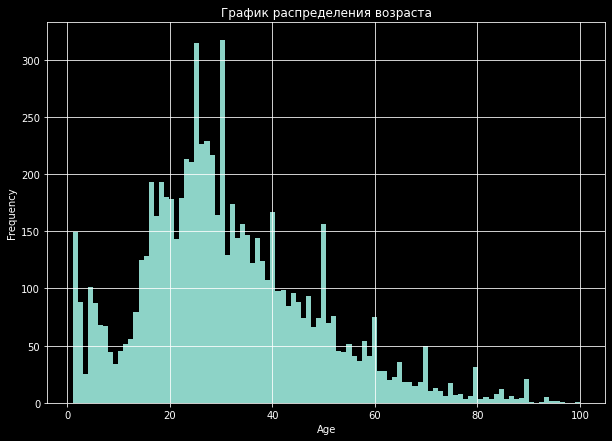

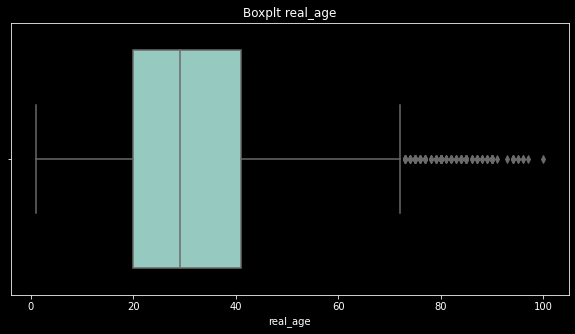

In [6]:
first_look(labels)

* У нас есть файл, состощий из столбцов с наименованием файлов (фичи) и возраста (таргет).
* Данные состоят из 7591 строки, пропущенных значений нет.
* Большинство людей в выборке находятся в возрасте от 20 до 40 лет.
* Пики в районе "юбилейных" лет, тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он его попросту округлял их. Поэтому, некоторые "круглые" года в датасете некорректные.

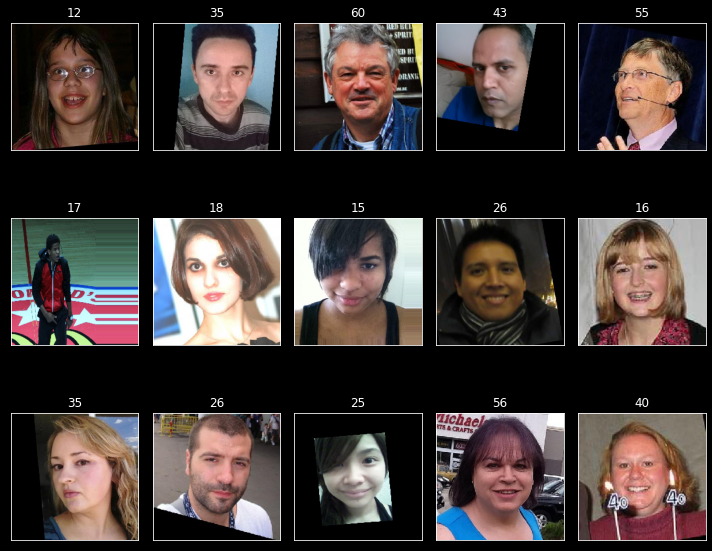

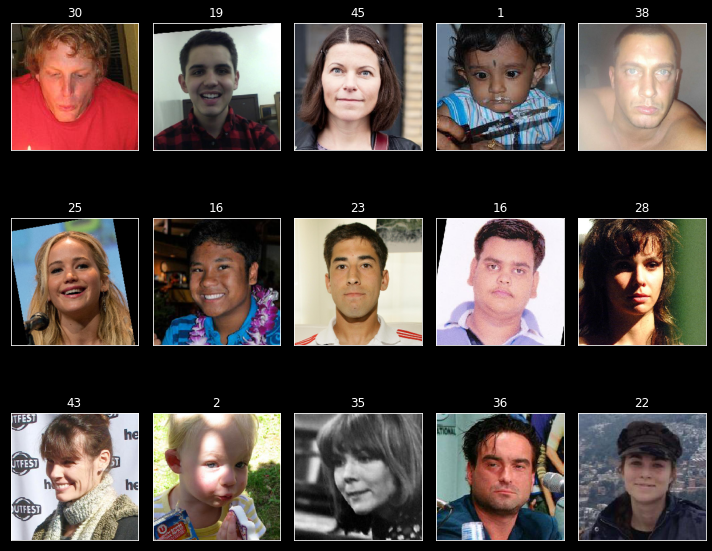

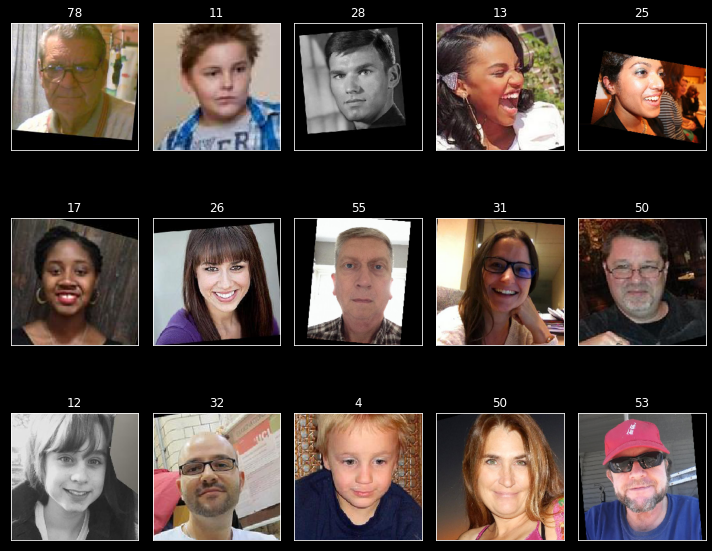

In [7]:
# 3 выборки по 15 изображений в каждой
for _ in range(3):
    features, target = next(train_gen_flow)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(15):
        fig.add_subplot(3, 5, i+1)
        plt.imshow(features[i])
        plt.title(target[i])
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        
    plt.show()

## Вывод по шагу

* 7591 фотография
* labels.csv имеет 2 столбца: Наименование фото объекта и его реальный возраст
* Большинство людей в выборке находятся в возрасте от 20 до 40 лет
* В данных присутствуют фотографии "старых" лет (черно-белые), некоторые изображения с неполностью открытым лицом, изображения имеют разный размер.

# 2. Обучение моделей

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

Я прикреплю код модели ResNet50, но буду рассматривать результаты нескольких моделей.

## 2.1 ResNet50

In [8]:
backbone = ResNet50(weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    input_shape=(224,224,3),
                    include_top=False)

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu'))

optimizer = Adam(lr=0.0002)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

2022-08-24 11:36:54.319780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 54s - loss: 205.7552 - mae: 10.5070 - val_loss: 709.7835 - val_mae: 21.7014
Epoch 2/10
356/356 - 45s - loss: 94.3166 - mae: 7.4009 - val_loss: 226.5823 - val_mae: 11.6957
Epoch 3/10
356/356 - 42s - loss: 72.5436 - mae: 6.4545 - val_loss: 116.1741 - val_mae: 8.0487
Epoch 4/10
Epoch 5/10
356/356 - 42s - loss: 59.5606 - mae: 5.8967 - val_loss: 78.7849 - val_mae: 6.7936
356/356 - 45s - loss: 42.3137 - mae: 4.9770 - val_loss: 89.6000 - val_mae: 6.9859
Epoch 6/10
356/356 - 45s - loss: 34.0821 - mae: 4.4767 - val_loss: 73.9650 - val_mae: 6.3746
Epoch 7/10
356/356 - 44s - loss: 27.6243 - mae: 4.0182 - val_loss: 73.1761 - val_mae: 6.3849
Epoch 8/10
356/356 - 44s - loss: 23.1777 - mae: 3.7018 - val_loss: 69.2860 - val_mae: 6.1999
Epoch 9/10
356/356 - 45s - loss: 17.7510 - mae: 3.2236 - val_loss: 86.2096 - val_mae: 7.1010
Epoch 10/10
356/356 - 44s - loss: 16.8265 - mae: 3.1272 - val_loss: 73.6152 - val_mae: 6.2867
119/119 - 11s - loss: 73.6152 - mae: 6.2867
Test MAE: 6.2867
```

### * Дополнительно

Если использовать батч размером 32, добавить пару слоёв и последний слой использовать с линейной активацией (она по дефолту), то сможем немного улучшить качество модели.

In [9]:
backbone = ResNet50(weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    input_shape=(224,224,3),
                    include_top=False)

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

optimizer = Adam(lr=0.0002)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 16)                32784     
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 23,620,641
Trainable params: 23,567,521
Non-trainable params: 53,120
_____________________________________

```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 53s - loss: 240.1193 - mae: 11.2458 - val_loss: 536.9617 - val_mae: 18.0881
Epoch 2/10
178/178 - 44s - loss: 86.0884 - mae: 7.0372 - val_loss: 562.6192 - val_mae: 18.6544
Epoch 3/10
178/178 - 43s - loss: 59.0075 - mae: 5.8121 - val_loss: 348.1829 - val_mae: 13.8266
Epoch 4/10
178/178 - 42s - loss: 46.4050 - mae: 5.1792 - val_loss: 128.0119 - val_mae: 8.7692
Epoch 5/10
178/178 - 43s - loss: 37.2800 - mae: 4.6337 - val_loss: 92.3485 - val_mae: 7.3760
Epoch 6/10
178/178 - 44s - loss: 28.6721 - mae: 4.1210 - val_loss: 107.5274 - val_mae: 7.8047
Epoch 7/10
178/178 - 43s - loss: 24.6547 - mae: 3.7985 - val_loss: 66.8462 - val_mae: 5.9937
Epoch 8/10
178/178 - 43s - loss: 20.1109 - mae: 3.4598 - val_loss: 92.2906 - val_mae: 7.4979
Epoch 9/10
178/178 - 41s - loss: 15.7387 - mae: 3.0584 - val_loss: 79.2294 - val_mae: 6.5787
Epoch 10/10
178/178 - 40s - loss: 13.2949 - mae: 2.7517 - val_loss: 62.0270 - val_mae: 5.8667
60/60 - 10s - loss: 62.0270 - mae: 5.8667
Test MAE: 5.8667
```

## 2.2 DenseNet169

In [10]:
model_summary(DenseNet169)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_2   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 12,486,145
Non-trainable params: 158,400
_________________________________________________________________


```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 99s - loss: 357.4788 - mae: 14.3020 - val_loss: 711.0305 - val_mae: 21.4747
Epoch 2/10
356/356 - 65s - loss: 134.8949 - mae: 8.7403 - val_loss: 81.6901 - val_mae: 6.9370
Epoch 3/10
356/356 - 66s - loss: 84.9722 - mae: 7.0677 - val_loss: 116.9218 - val_mae: 8.0019
Epoch 4/10
356/356 - 65s - loss: 63.5165 - mae: 6.1113 - val_loss: 127.1392 - val_mae: 8.9319
Epoch 5/10
356/356 - 65s - loss: 50.1618 - mae: 5.4858 - val_loss: 74.0974 - val_mae: 6.6448
Epoch 6/10
356/356 - 65s - loss: 40.4441 - mae: 4.9167 - val_loss: 88.5859 - val_mae: 7.1807
Epoch 7/10
356/356 - 65s - loss: 32.0984 - mae: 4.3618 - val_loss: 76.1665 - val_mae: 6.3835
Epoch 8/10
356/356 - 65s - loss: 25.7003 - mae: 3.8880 - val_loss: 80.2320 - val_mae: 6.6996
Epoch 9/10
356/356 - 65s - loss: 22.7557 - mae: 3.6757 - val_loss: 76.9368 - val_mae: 6.6126
Epoch 10/10
356/356 - 65s - loss: 20.2194 - mae: 3.4595 - val_loss: 80.6258 - val_mae: 6.3849
119/119 - 11s - loss: 80.6258 - mae: 6.3849
Test MAE: 6.3849
```

## 2.3 InceptionV3

In [11]:
model_summary(InceptionV3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 63s - loss: 361.5715 - mae: 14.3364 - val_loss: 217.8733 - val_mae: 11.3537
Epoch 2/10
356/356 - 48s - loss: 126.4457 - mae: 8.5869 - val_loss: 86.0813 - val_mae: 6.9337
Epoch 3/10
356/356 - 48s - loss: 85.1515 - mae: 7.1039 - val_loss: 89.0196 - val_mae: 7.1056
Epoch 4/10
356/356 - 48s - loss: 63.7335 - mae: 6.1137 - val_loss: 97.4124 - val_mae: 7.8486
Epoch 5/10
356/356 - 48s - loss: 50.5454 - mae: 5.4660 - val_loss: 73.2718 - val_mae: 6.5609
Epoch 6/10
356/356 - 45s - loss: 40.9372 - mae: 4.8416 - val_loss: 115.7067 - val_mae: 8.4300
Epoch 7/10
356/356 - 44s - loss: 32.3662 - mae: 4.2903 - val_loss: 84.5273 - val_mae: 6.7977
Epoch 8/10
356/356 - 48s - loss: 25.2826 - mae: 3.8510 - val_loss: 68.2498 - val_mae: 6.2565
Epoch 9/10
356/356 - 48s - loss: 22.6071 - mae: 3.6877 - val_loss: 73.1911 - val_mae: 6.2682
Epoch 10/10
356/356 - 48s - loss: 20.1020 - mae: 3.4166 - val_loss: 66.5360 - val_mae: 6.0363
119/119 - 11s - loss: 66.5360 - mae: 6.0363
Test MAE: 6.0363
```

## 2.4 InceptionResNetV2

In [12]:
model_summary(InceptionResNetV2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_4   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 54,338,273
Trainable params: 54,277,729
Non-trainable params: 60,544
_________________________________________________________________


```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 97s - loss: 350.5905 - mae: 14.2790 - val_loss: 151.5258 - val_mae: 9.3142
Epoch 2/10
356/356 - 67s - loss: 115.9888 - mae: 8.2183 - val_loss: 10115.2360 - val_mae: 23.1333
Epoch 3/10
356/356 - 76s - loss: 77.1335 - mae: 6.6864 - val_loss: 188.2920 - val_mae: 8.0846
Epoch 4/10
356/356 - 77s - loss: 59.0198 - mae: 5.9190 - val_loss: 73.4453 - val_mae: 6.3417
Epoch 5/10
356/356 - 78s - loss: 43.5590 - mae: 5.0944 - val_loss: 89.0927 - val_mae: 7.1323
Epoch 6/10
356/356 - 75s - loss: 33.9670 - mae: 4.4903 - val_loss: 94.1690 - val_mae: 7.6885
Epoch 7/10
356/356 - 73s - loss: 27.5549 - mae: 4.0292 - val_loss: 85.3276 - val_mae: 6.7792
Epoch 8/10
356/356 - 76s - loss: 22.2373 - mae: 3.6599 - val_loss: 118.9294 - val_mae: 6.6859
Epoch 9/10
356/356 - 78s - loss: 19.4079 - mae: 3.3552 - val_loss: 77.7400 - val_mae: 6.2994
Epoch 10/10
356/356 - 78s - loss: 17.2574 - mae: 3.1642 - val_loss: 68.4951 - val_mae: 5.9774
119/119 - 12s - loss: 68.4951 - mae: 5.9774
Test MAE: 5.9774
```

## 2.5 Xception

In [13]:
model_summary(Xception)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 66s - loss: 446.9272 - mae: 16.7013 - val_loss: 92.5551 - val_mae: 7.2638
Epoch 2/10
356/356 - 57s - loss: 91.8157 - mae: 7.2319 - val_loss: 100.4458 - val_mae: 7.6997
Epoch 3/10
Epoch 4/10
356/356 - 58s - loss: 54.3102 - mae: 5.7239 - val_loss: 96.0177 - val_mae: 7.2456
356/356 - 57s - loss: 42.2555 - mae: 4.9747 - val_loss: 65.3269 - val_mae: 6.1310
Epoch 5/10
356/356 - 57s - loss: 33.6861 - mae: 4.5148 - val_loss: 74.6910 - val_mae: 6.3173
Epoch 6/10
356/356 - 57s - loss: 28.7944 - mae: 4.1273 - val_loss: 59.2505 - val_mae: 5.7481
Epoch 7/10
356/356 - 57s - loss: 20.6739 - mae: 3.5136 - val_loss: 66.5664 - val_mae: 6.3230
Epoch 8/10
356/356 - 57s - loss: 16.4224 - mae: 3.1247 - val_loss: 61.4890 - val_mae: 5.9098
Epoch 9/10
356/356 - 57s - loss: 13.4982 - mae: 2.7843 - val_loss: 61.7162 - val_mae: 5.9323
Epoch 10/10
356/356 - 57s - loss: 11.4428 - mae: 2.5498 - val_loss: 60.6063 - val_mae: 5.7452
119/119 - 9s - loss: 60.6063 - mae: 5.7452
Test MAE: 5.7452
```

# 3. Анализ моделей

In [14]:
# таблица с результатами моделей (val_mae)
col = [f'{n} epoch' for n in range(1, 11)]
ind = [
    'ResNet50',
    'DenseNet169',
    'InceptionV3',
    'InceptionResNetV2',
    'Xception',
]

report_val_mae = pd.DataFrame(
    columns=col,
    index=ind
)

resnet = [21.7014, 11.6957, 8.0487, 6.7936, 6.9859, 6.3746, 6.3849, 6.1999, 7.1010, 6.2867,]
densenet = [21.4747, 6.9370, 8.0019, 8.9319, 6.6448, 7.1807, 6.3835, 6.6996, 6.6126, 6.3849,]
inception = [11.3537, 6.9337, 7.1056, 7.8486, 6.5609, 8.4300, 6.7977, 6.2565, 6.2682, 6.0363,]
inceptionresnet = [9.3142, 23.1333, 8.0846, 6.3417, 7.1323, 7.6885, 6.7792, 6.6859, 6.2994, 5.9774,]
xception = [7.2638, 7.6997, 7.2456, 6.1310, 6.3173, 5.7481, 6.3230, 5.9098, 5.9323, 5.7452]

report_val_mae.iloc[0] = resnet
report_val_mae.iloc[1] = densenet
report_val_mae.iloc[2] = inception
report_val_mae.iloc[3] = inceptionresnet
report_val_mae.iloc[4] = xception
del resnet, densenet, inception, inceptionresnet, xception


# таблица с результатами моделей (val_loss)
report_val_loss = pd.DataFrame(
    columns=col,
    index=ind
)
del col, ind

resnet = [709.7835, 226.5823, 116.1741, 78.7849, 89.6000, 73.9650, 73.1761, 69.2860, 86.2096, 73.6152,]
densenet = [711.0305, 81.6901, 116.9218, 127.1392, 74.0974, 88.5859, 76.1665, 80.2320, 76.9368, 80.6258,]
inception = [217.8733, 86.0813, 89.0196, 97.4124, 73.2718, 115.7067, 84.5273, 68.2498, 73.1911, 66.5360,]
inceptionresnet = [151.5258, 10115.2360, 188.2920, 73.4453, 89.0927, 94.1690, 85.3276, 118.9294, 77.7400, 68.4951,]
xception = [92.5551, 100.4458, 96.0177, 65.3269, 74.6910, 59.2505, 66.5664, 61.4890, 61.7162, 60.6063,]

report_val_loss.iloc[0] = resnet
report_val_loss.iloc[1] = densenet
report_val_loss.iloc[2] = inception
report_val_loss.iloc[3] = inceptionresnet
report_val_loss.iloc[4] = xception
del resnet, densenet, inception, inceptionresnet, xception

Результаты val_loss:


,1 epoch,2 epoch,3 epoch,4 epoch,5 epoch,6 epoch,7 epoch,8 epoch,9 epoch,10 epoch
ResNet50,709.7835,226.5823,116.1741,78.7849,89.6,73.965,73.1761,69.286,86.2096,73.6152
DenseNet169,711.0305,81.6901,116.9218,127.1392,74.0974,88.5859,76.1665,80.232,76.9368,80.6258
InceptionV3,217.8733,86.0813,89.0196,97.4124,73.2718,115.7067,84.5273,68.2498,73.1911,66.536
InceptionResNetV2,151.5258,10115.236,188.292,73.4453,89.0927,94.169,85.3276,118.9294,77.74,68.4951
Xception,92.5551,100.4458,96.0177,65.3269,74.691,59.2505,66.5664,61.489,61.7162,60.6063




Результаты val_mae:


,1 epoch,2 epoch,3 epoch,4 epoch,5 epoch,6 epoch,7 epoch,8 epoch,9 epoch,10 epoch
ResNet50,21.7014,11.6957,8.0487,6.7936,6.9859,6.3746,6.3849,6.1999,7.101,6.2867
DenseNet169,21.4747,6.937,8.0019,8.9319,6.6448,7.1807,6.3835,6.6996,6.6126,6.3849
InceptionV3,11.3537,6.9337,7.1056,7.8486,6.5609,8.43,6.7977,6.2565,6.2682,6.0363
InceptionResNetV2,9.3142,23.1333,8.0846,6.3417,7.1323,7.6885,6.7792,6.6859,6.2994,5.9774
Xception,7.2638,7.6997,7.2456,6.131,6.3173,5.7481,6.323,5.9098,5.9323,5.7452


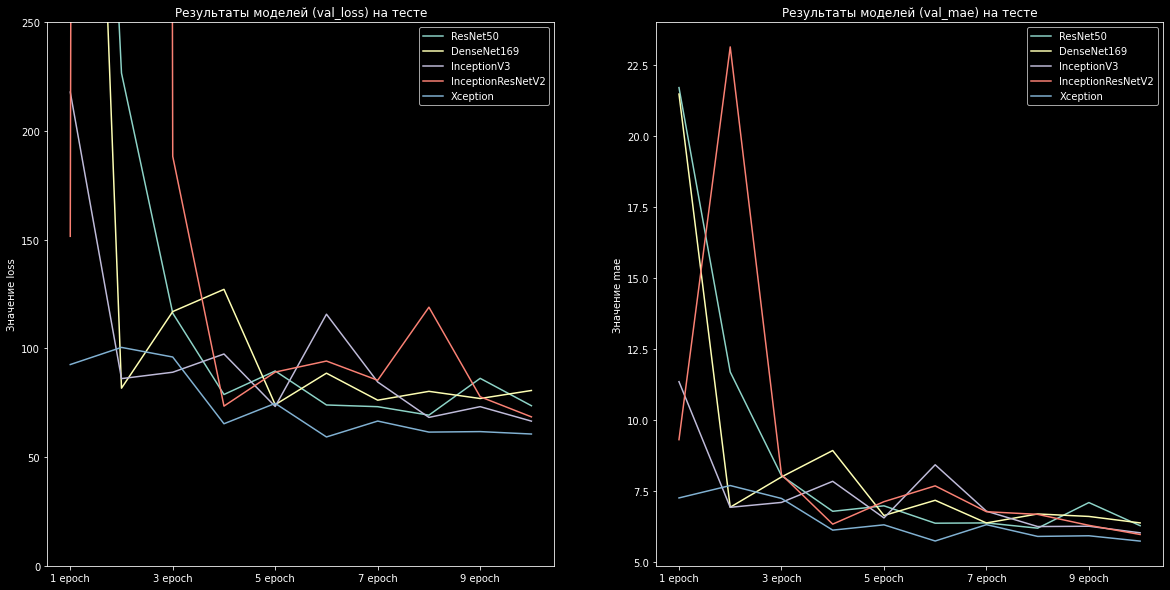

In [15]:
print('Результаты val_loss:')
display(report_val_loss)

print('\n\nРезультаты val_mae:')
display(report_val_mae)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

report_val_loss.T.plot(
    ax=axs[0],
    ylim=[0,250],
    ylabel='Значение loss',
    title='Результаты моделей (val_loss) на тесте'
)

report_val_mae.T.plot( 
    ax=axs[1],
    ylabel='Значение mae',
    title='Результаты моделей (val_mae) на тесте'
)
plt.show()

# Вывод

Исходя из полученных результатов, все модели успешно справились с поставленной задачей, а именно преодалели порог MAE=8 на тестовой выборке. Лучше всего себя показала модель **Xception** т.к. у нее самые 'плавные' графики сходимости и наименьший mae из рассмотренных моделей.

При обучении `Xception` мы добились значения **MAE** `2.5498` на обучающей выборке и `5.7452` на тестовой.